In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

import datetime as dt

In [3]:
# Reflect Tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
db_tbls_scma = automap_base()
db_tbls_scma.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
db_tbls_scma.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement_tbl = db_tbls_scma.classes.measurement
station_tbl = db_tbls_scma.classes.station

In [8]:
# Create our session (link) from Python to the DB
sqla_session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Rain in Inches')

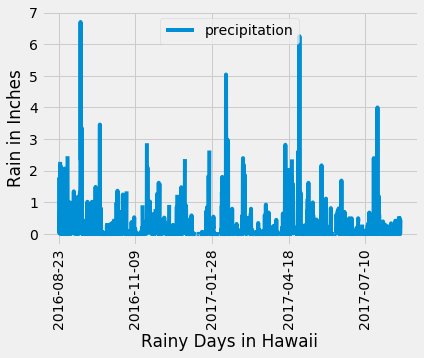

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

weather_data = sqla_session.execute("SELECT m.date, m.prcp FROM measurement m WHERE m.date >= (SELECT DATE(max(date),'-365 day') FROM measurement)")

# Save the query results as a Pandas DataFrame and set the index to the date column

weather_df = pd.DataFrame(weather_data, columns=['date', 'precipitation'])
weather_df.set_index("date", inplace=True)

# Sort the dataframe by date
weather_df.sort_values("date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
weather_df.plot(rot=90)
plt.xlabel("Rainy Days in Hawaii")
plt.ylabel("Rain in Inches")

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
print(f"There are {sqla_session.query(func.count(station_tbl.station)).all()[0][0]} weather stations avaiable")

There are 9 weather stations avaiable


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data = sqla_session.query(measurement_tbl.station, func.count(measurement_tbl.station)).\
    group_by(measurement_tbl.station).order_by(func.count(measurement_tbl.station).desc()).all()

for row in station_data:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
result = sqla_session.query(func.min(measurement_tbl.tobs), func.max(measurement_tbl.tobs), func.avg(measurement_tbl.tobs)).\
    filter(measurement_tbl.station == station_data[0][0]).all()
print(f"Temperatures: Lowest ({result[0][0]}), Highest ({result[0][1]}), Average ({result[0][2]}) as recorded at Station, ID #{station_data[0][0]}")

Temperatures: Lowest (54.0), Highest (85.0), Average (71.66378066378067) as recorded at Station, ID #USC00519281


Text(9.435000000000002, 0.5, 'Total Days at temp')

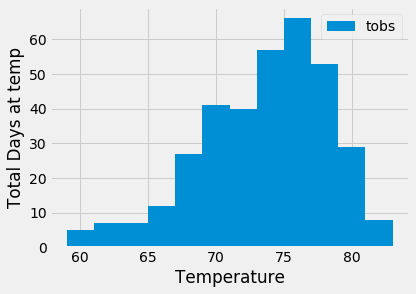

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
datepull = sqla_session.execute("SELECT DATE(max(date),'-365 day') FROM measurement")
date_list = list(datepull)[0][0]
 
result = sqla_session.query(measurement_tbl.tobs).\
    filter(measurement_tbl.station == station_data[0][0]).\
    filter(measurement_tbl.date >= date_list).all()

df = pd.DataFrame(result, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")
plt.ylabel("Total Days at temp")

## Bonus Challenge Assignment

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return sqla_session.query(func.min(measurement_tbl.tobs), func.avg(measurement_tbl.tobs), func.max(measurement_tbl.tobs)).\
        filter(measurement_tbl.date >= start_date).filter(measurement_tbl.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
year_start = dt.date(2018, 1, 1) - dt.timedelta(days=365)
year_end = dt.date(2018, 1, 7) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(year_start.strftime("%Y-%m-%d"), year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


C:\Users\SeaLord\anaconda37\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


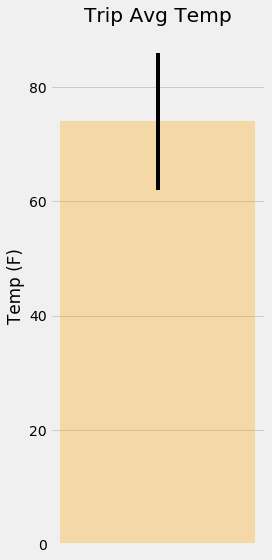

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))

barchart = ax.bar(1,
             tmax,
             yerr=tmax-tmin,
             alpha=0.3,
             color='orange',
             align="center")

ax.set(xticks=range(xpos),
       xticklabels="a",
       title="Trip Avg Temp",
       ylabel="Temp (F)"
      )

fig.tight_layout()
fig.show()

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [station_tbl.station, station_tbl.name, station_tbl.latitude, 
       station_tbl.longitude, station_tbl.elevation, func.sum(measurement_tbl.prcp)]

result = sqla_session.query(*sel).\
    filter(measurement_tbl.station == station_tbl.station).\
    filter(measurement_tbl.date >= year_start).\
    filter(measurement_tbl.date <= year_end).\
    group_by(station_tbl.name).order_by(func.sum(measurement_tbl.prcp).desc()).all()
result_df = pd.DataFrame(result, columns=['Station ID', 'Station Name', 'precipitation', 'Latitude', 'Longitude', 'Elevation'])
result_df

,Station ID,Station Name,precipitation,Latitude,Longitude,Elevation
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement_tbl.tobs), func.avg(measurement_tbl.tobs), func.max(measurement_tbl.tobs)]

    return sqla_session.query(*sel).filter(func.strftime("%m-%d", measurement_tbl.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [47]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip_dates = pd.date_range('2018-01-01', '2018-01-07', freq='D')

# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norm = []
for date in trip_month_day:
    daily_norm.append(*daily_normals(date))

#daily_norm

In [45]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norm_df = pd.DataFrame(daily_norm, columns=['tmin', 'tavg', 'tmax'])
daily_norm_df['date'] = trip_dates
daily_norm_df.set_index(['date'],inplace=True)
daily_norm_df

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


Text(9.435000000000002, 0.5, 'Temperature')

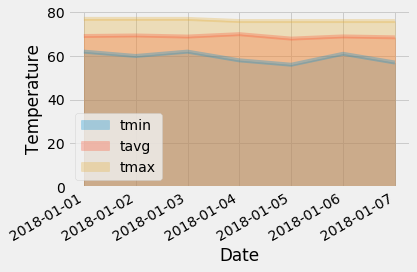

In [46]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norm_df.plot(kind='area',
                   stacked=False,
                   x_compat=True,
                   alpha=.3)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")